In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
!pip install timm


In [8]:
import os
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from timm import create_model

# Dataset Preparation
class ChestXRayDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = 0 if "NORMAL" in img_path else 1  # Assign 0 for NORMAL, 1 for PNEUMONIA
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Paths to the Dataset
train_files = glob.glob("/kaggle/input/chest-xray-pneumonia/chest_xray/train/**/*.jpeg")
test_files = glob.glob("/kaggle/input/chest-xray-pneumonia/chest_xray/test/**/*.jpeg")
val_files = glob.glob("/kaggle/input/chest-xray-pneumonia/chest_xray/val/**/*.jpeg")

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create Datasets and Dataloaders
train_dataset = ChestXRayDataset(train_files, transform=transform)
test_dataset = ChestXRayDataset(test_files, transform=transform)
val_dataset = ChestXRayDataset(val_files, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load Swin Transformer Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=2)
model = model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training Loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Calculate Training Metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Calculate Validation Metrics
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

        # Log Epoch Metrics
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n")

# Evaluation Function
def evaluate_model(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(data_loader)
    val_accuracy = correct / total

    return val_loss, val_accuracy

# Train the Model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Test the Model
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10:
  Train Loss: 0.1272, Train Accuracy: 0.9517
  Val Loss: 0.0042, Val Accuracy: 1.0000

Epoch 2/10:
  Train Loss: 0.0506, Train Accuracy: 0.9826
  Val Loss: 0.0495, Val Accuracy: 1.0000

Epoch 3/10:
  Train Loss: 0.0277, Train Accuracy: 0.9898
  Val Loss: 1.4434, Val Accuracy: 0.6250

Epoch 4/10:
  Train Loss: 0.0216, Train Accuracy: 0.9923
  Val Loss: 1.3921, Val Accuracy: 0.6250

Epoch 5/10:
  Train Loss: 0.0171, Train Accuracy: 0.9941
  Val Loss: 0.3681, Val Accuracy: 0.9375

Epoch 6/10:
  Train Loss: 0.0214, Train Accuracy: 0.9925
  Val Loss: 0.0054, Val Accuracy: 1.0000

Epoch 7/10:
  Train Loss: 0.0147, Train Accuracy: 0.9942
  Val Loss: 0.0012, Val Accuracy: 1.0000

Epoch 8/10:
  Train Loss: 0.0073, Train Accuracy: 0.9973
  Val Loss: 0.5046, Val Accuracy: 0.8125

Epoch 9/10:
  Train Loss: 0.0057, Train Accuracy: 0.9983
  Val Loss: 0.0013, Val Accuracy: 1.0000

Epoch 10/10:
  Train Loss: 0.0082, Train Accuracy: 0.9981
  Val Loss: 0.0008, Val Accuracy: 1.0000

Test Loss

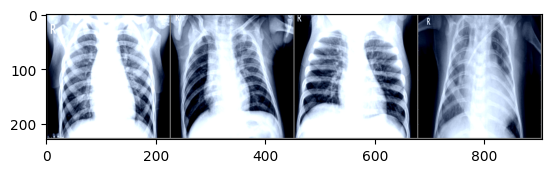

True Labels: [1 1 1 1]
Predicted Labels: [1 1 1 1]


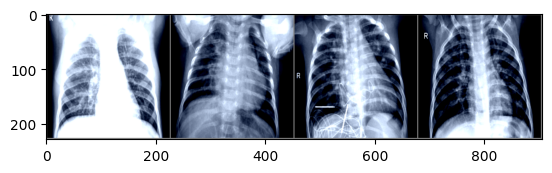

True Labels: [1 1 1 1]
Predicted Labels: [1 1 1 1]


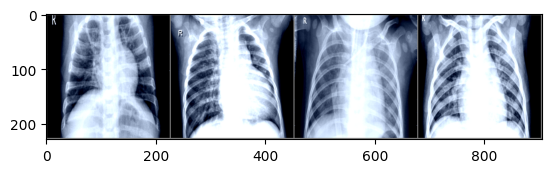

True Labels: [1 1 1 1]
Predicted Labels: [1 1 1 1]


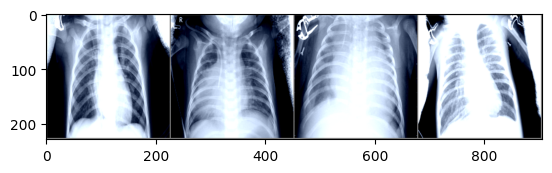

True Labels: [1 1 1 1]
Predicted Labels: [1 1 1 1]


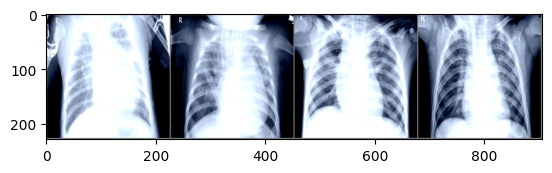

True Labels: [1 1 1 1]
Predicted Labels: [1 1 1 1]


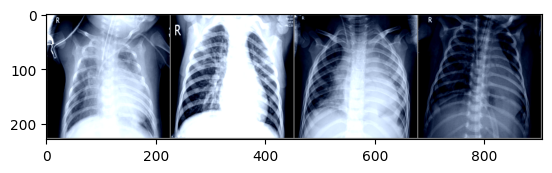

True Labels: [1 1 1 1]
Predicted Labels: [1 1 1 1]


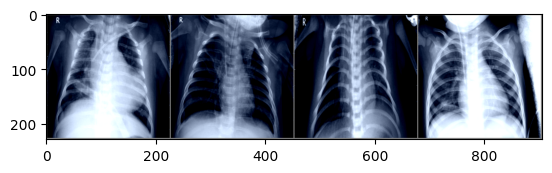

True Labels: [1 1 1 1]
Predicted Labels: [1 1 1 1]


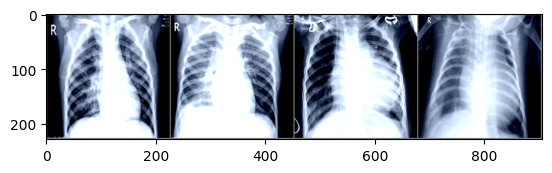

True Labels: [1 1 1 1]
Predicted Labels: [1 1 1 1]


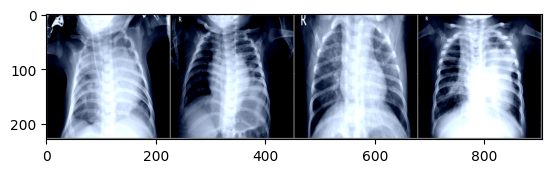

True Labels: [1 1 1 1]
Predicted Labels: [1 1 1 1]


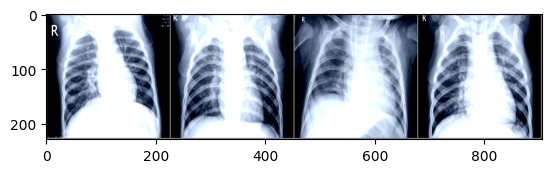

True Labels: [1 1 1 1]
Predicted Labels: [1 1 1 1]


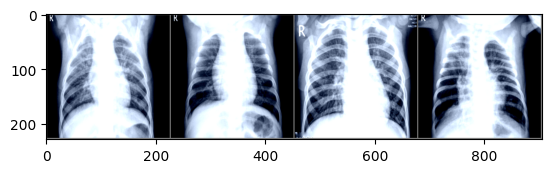

True Labels: [1 1 1 1]
Predicted Labels: [1 1 1 1]


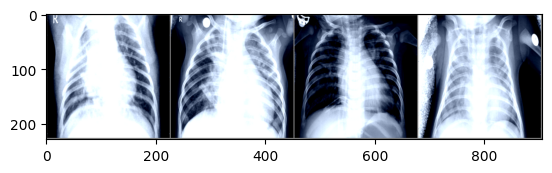

True Labels: [1 1 1 1]
Predicted Labels: [1 1 1 1]


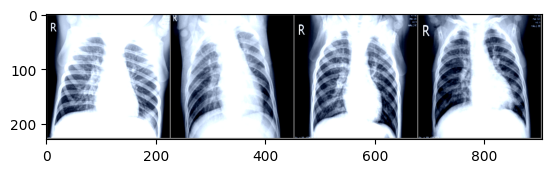

True Labels: [1 1 1 1]
Predicted Labels: [1 1 1 1]


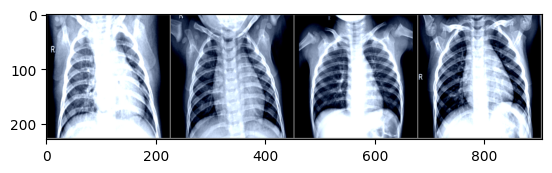

True Labels: [0 0 0 0]
Predicted Labels: [1 0 0 0]


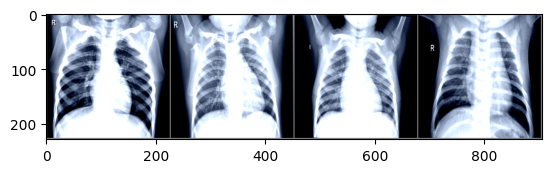

True Labels: [0 0 0 0]
Predicted Labels: [0 0 0 0]


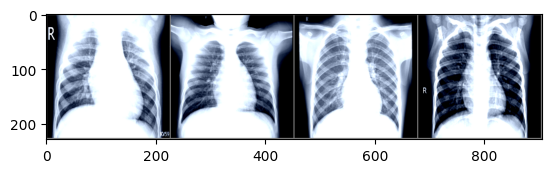

True Labels: [0 0 0 0]
Predicted Labels: [1 1 1 1]


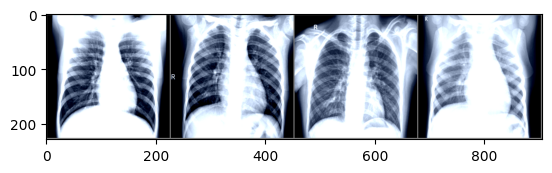

True Labels: [0 0 0 0]
Predicted Labels: [1 0 1 1]


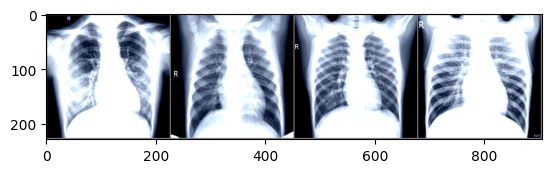

True Labels: [0 0 0 0]
Predicted Labels: [1 1 0 1]


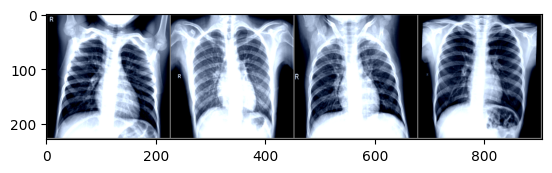

True Labels: [0 0 0 0]
Predicted Labels: [0 1 1 1]


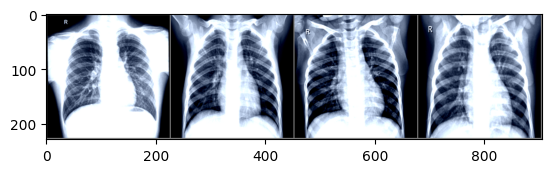

True Labels: [0 0 0 0]
Predicted Labels: [0 0 0 1]
Test Loss: 1.4981, Test Accuracy: 0.8109


In [11]:
# Function to unnormalize and plot images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.cpu().numpy()  # Move the tensor to CPU and convert to a numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from Tensor CHW to HWC
    plt.show()

# Evaluation Function with Image Visualization
def evaluate_model(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Show sample images during evaluation (e.g., first 4 images in the batch)
            imshow(torchvision.utils.make_grid(images[:4]))  # Display the first 4 images in the batch
            print('True Labels:', labels[:4].cpu().numpy())  # Print the true labels of the displayed images
            print('Predicted Labels:', predicted[:4].cpu().numpy())  # Print the predicted labels

    val_loss = running_loss / len(data_loader)
    val_accuracy = correct / total

    return val_loss, val_accuracy

test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")